# Numerical Optimization with Python - Final Project

## Optimizing a power generation schedule

In [3]:
#Library to install
%pip install networkx seaborn pandas numpy gurobipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
#imports
import requests
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings
import gurobipy as gp
import numpy as np
warnings.filterwarnings("ignore")

In [3]:
df_demand = pd.read_csv('demand.csv')
df_demand.head(20)


,YEAR,MONTH,DAY,HOUR,LOAD
0,2004,1,6,22,9109.936201
1,2004,1,20,2,9822.877378
2,2004,1,14,16,8026.406790
3,2004,1,26,5,7649.936201
4,2004,1,5,16,7842.877378
5,2004,1,23,12,9099.347966
6,2004,1,31,14,9044.053848
7,2004,1,30,5,8518.759731
8,2004,1,30,24,9418.171495
9,2004,1,21,14,9835.818554


In [4]:
specific_day = df_demand[(df_demand['YEAR']==2011)&(df_demand['MONTH']==7)&(df_demand['DAY']==1)] 
specific_day.sort_values(by='HOUR')

,YEAR,MONTH,DAY,HOUR,LOAD
13104,2011,7,1,1,11212.289140
13018,2011,7,1,2,10144.430320
12856,2011,7,1,3,8981.030319
13361,2011,7,1,4,8292.642084
13384,2011,7,1,5,7988.171495
13305,2011,7,1,6,7843.465613
13077,2011,7,1,7,7476.406790
12911,2011,7,1,8,7309.347966
12658,2011,7,1,9,7337.583260
13320,2011,7,1,10,7682.877378


In [5]:
demand = specific_day.set_index(['HOUR']).LOAD.to_dict()
hours = set(demand.keys())

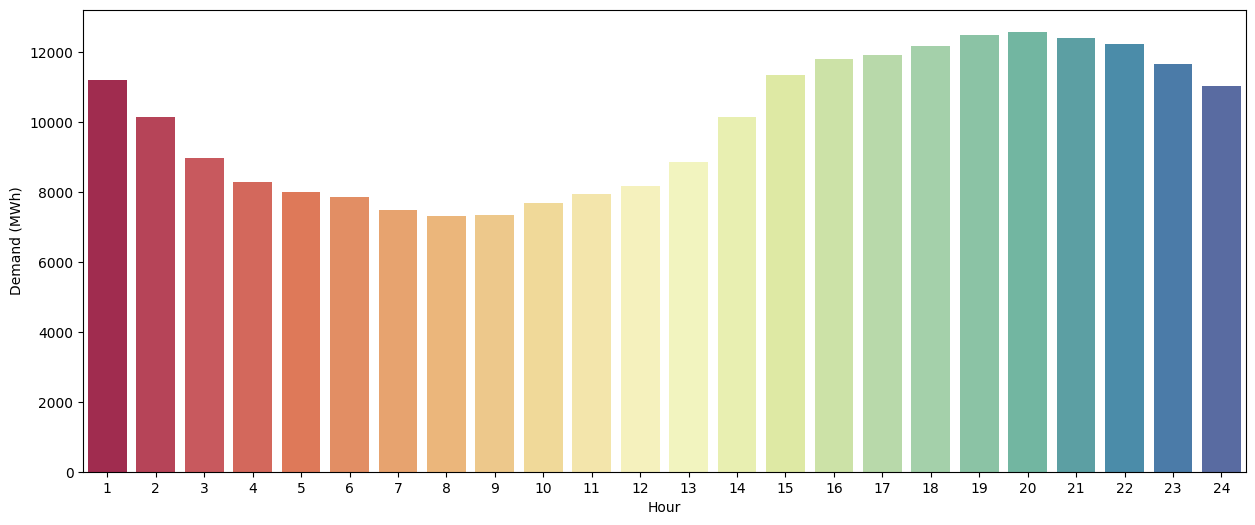

In [6]:

fig, ax = plt.subplots(figsize=(15,6)) 

# Define a palette with different colors
palette = sns.color_palette("Spectral", 24)  # 24 different colors

# Plot the barplot with the defined palette
specific_day_plot = sns.barplot(x=list(range(1,25)), y=[demand[h] for h in range(1,25)], palette=palette)
specific_day_plot.set_xticklabels(specific_day_plot.get_xticklabels())
specific_day_plot.set(xlabel='Hour', ylabel='Demand (MWh)')

plt.show()

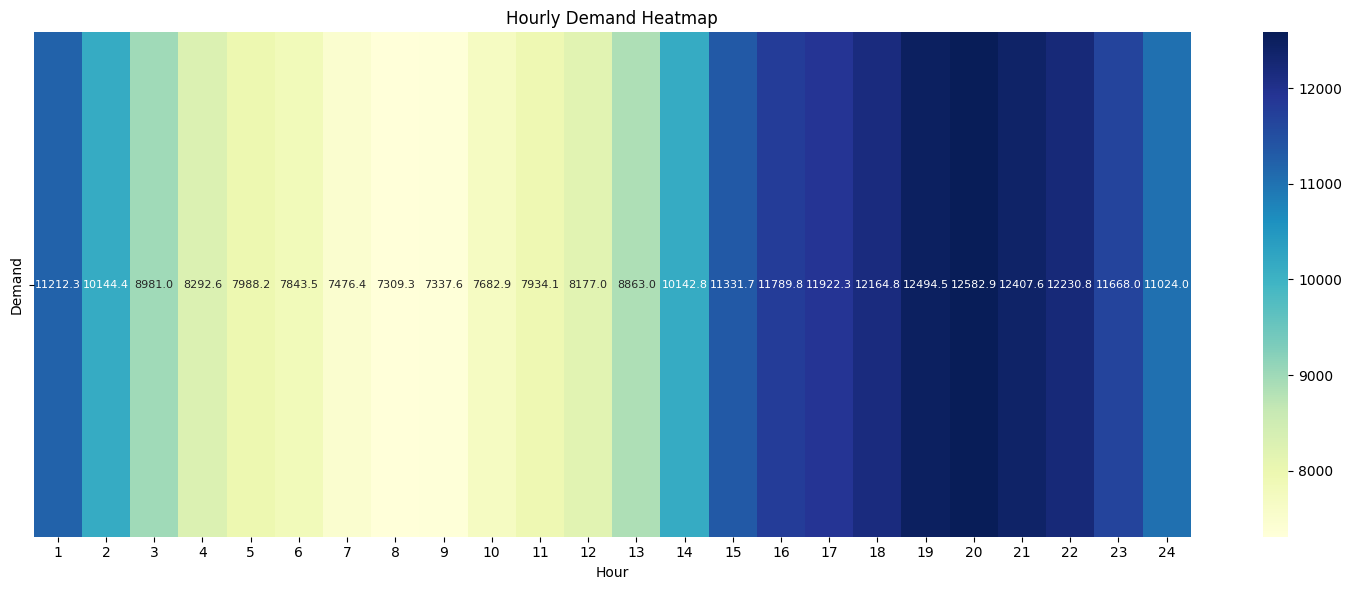

In [9]:

# Assuming 'demand' is a dictionary or series with hourly demand data
hours = list(range(1, 25))
demand_data = [demand[h] for h in range(1, 25)]

# Create the heatmap data array
data = np.array(demand_data).reshape(1, -1)

# Create the heatmap
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(data, cmap="YlGnBu", cbar=True, annot=True, fmt=".1f", xticklabels=hours, yticklabels=['Demand'], annot_kws={"size": 8})

# Adjust tick parameters for better readability
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Hour')
ax.set_title('Hourly Demand Heatmap')

# Use tight layout to avoid clipping
plt.tight_layout()
plt.show()

In [ ]:
# Separation

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Create the model
model = gp.Model("generation-schedule-optimization")

# Define the variables
z = model.addVars(P, H, name="z", lb=0)  # power generated in each plant for each hour
u = model.addVars(P, H, name="u", vtype=GRB.BINARY, lb=0)  # is the plant on? for each plant and hour
v = model.addVars(P, H, name="v", vtype=GRB.BINARY)  # start up the plant? for each plant and hour
w = model.addVars(P, H, name="w", vtype=GRB.BINARY)  # shut down the plant? for each plant and hour

# Define the cost components
fuel_cost = gp.quicksum(f[i] * z[i, h] for i in P for h in H)
health_cost = gp.quicksum(a[i, h] * z[i, h] for i in P for h in H)
operating_cost = gp.quicksum(o[i] * u[i, h] for i in P for h in H)
startup_cost = gp.quicksum(s[i] * v[i, h] for i in P for h in H)
shutdown_cost = gp.quicksum(t[i] * w[i, h] for i in P for h in H)

# Set the objective function by summing all the costs
total_cost = fuel_cost + health_cost + operating_cost + startup_cost + shutdown_cost
model.setObjective(total_cost, sense=GRB.MINIMIZE)

# Define the constraints
# Demand satisfaction constraint
model.addConstrs((gp.quicksum(z[i, h] for i in P) == d[h]) for h in H)

# Minimum and maximum generation limits
model.addConstrs((z[i, h] >= m[i] * c[i] * u[i, h]) for i in P for h in H)
model.addConstrs((z[i, h] <= c[i] * u[i, h]) for i in P for h in H)

# Keep nuclear power plants always on
model.addConstrs((z[i, h] >= m[i] * c[i]) for i in P_N for h in H)

# Ramp-up and ramp-down constraints
model.addConstrs((z[i, h] - z[i, h-1] >= -r[i] * c[i]) for i in P for h in H if h > 1)
model.addConstrs((z[i, h] - z[i, h-1] <= r[i] * c[i]) for i in P for h in H if h > 1)

# Startup and shutdown logic constraints
model.addConstrs((v[i, h] <= u[i, h]) for i in P for h in H)
model.addConstrs((w[i, h] <= 1 - u[i, h]) for i in P for h in H)
model.addConstrs((v[i, h] - w[i, h] == u[i, h] - u[i, h-1]) for i in P for h in H if h > 1)

# Solve the model
model.optimize()


In [ ]:
# Create the solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

# Populate the solution DataFrame
solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Plot the power supply
print("Power supply:")
fig, ax = plt.subplots(figsize=(15, 6))
sns.pointplot(data=solution, x='Hour', y='Power generated (MWh)', hue='Plant')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Create the demand DataFrame
demand = pd.DataFrame({
    'Hour': list(H),
    'Demand (MWh)': [d[h] for h in H]
})

# Plot the power demand
print("Power demand:")
fig, ax = plt.subplots(figsize=(15, 6))
sns.pointplot(data=demand, x='Hour', y='Demand (MWh)')
plt.show()


In [ ]:
plant_capacities = {i: c[i] for i in P}

# Create solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Ensure the x-axis includes all hours from 1 to 24
hours = range(1, 25)

# Number of plants per row
plants_per_row = 3

# Create subplots
fig, axes = plt.subplots(nrows=(len(P) + plants_per_row - 1) // plants_per_row, ncols=plants_per_row, figsize=(18, 12))
axes = axes.flatten()

# Plotting the results for each plant
for idx, plant in enumerate(P):
    ax = axes[idx]
    plant_solution = solution[solution['Plant'] == plant]
    energy_per_hour = plant_solution.groupby('Hour')['Power generated (MWh)'].sum().reindex(hours, fill_value=0)
    ax.plot(energy_per_hour.index, energy_per_hour.values, label=f'{plant} Energy Produced')

    # Adding the plant's minimum and maximum operating lines
    min_operating_power = 0.01 * plant_capacities[plant] if plant not in P_N else 0.8 * plant_capacities[plant]
    max_operating_power = plant_capacities[plant]
    ax.plot(hours, [min_operating_power] * len(hours), linestyle=':', label=f'{plant} Min Capacity ({min_operating_power} MWh)')
    ax.plot(hours, [max_operating_power] * len(hours), linestyle='--', label=f'{plant} Max Capacity ({max_operating_power} MWh)')

    ax.set_title(f'Energy Produced by {plant} Per Hour')
    ax.set_xlabel('Hour')
    ax.set_xticks(hours)  # Set x-axis ticks to be one by one from 1 to 24
    ax.set_ylabel('Energy (MWh)')
    ax.legend()

# Hide any unused subplots
for i in range(len(P), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
plant_ramp_rates = {i: r[i] for i in P}

# Create solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Calculate the differences between consecutive hours for each plant
solution['Power_diff'] = solution.groupby('Plant')['Power generated (MWh)'].diff()

# Create a DataFrame to check constraints
check_constraints_list = []

# Ensure the x-axis includes all hours from 1 to 24
hours = range(1, 25)

# Calculate and check constraints
for plant in P:
    plant_solution = solution[solution['Plant'] == plant]
    for hour in hours:
        if hour > 1:
            power_diff = plant_solution.loc[plant_solution['Hour'] == hour, 'Power_diff']
            if not power_diff.empty:
                power_diff_value = power_diff.values[0]
                max_ramp_up = plant_ramp_rates[plant] * plant_capacities[plant]
                max_ramp_down = -plant_ramp_rates[plant] * plant_capacities[plant]
                ramp_up_ok = power_diff_value <= max_ramp_up
                ramp_down_ok = power_diff_value >= max_ramp_down
                check_constraints_list.append({
                    'Plant': plant,
                    'Hour': hour,
                    'Power_diff': power_diff_value,
                    'Max Ramp Up': max_ramp_up,
                    'Max Ramp Down': max_ramp_down,
                    'Ramp Up OK': ramp_up_ok,
                    'Ramp Down OK': ramp_down_ok
                })

check_constraints = pd.DataFrame(check_constraints_list)


# Display the table
check_constraints